In [371]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from learned_tuning.learned_tuning import calculate_learned_tuning_PBE_subsets, calculate_place_field_fidelity_of_learned_tuning, calculate_all_column_correlations


%matplotlib widget


def gausswindow(sigma, halfwidth):
    """
    Compute a Gaussian window function.

    Parameters
    ----------
    sigma : float
        Standard deviation of the Gaussian distribution.
    halfwidth : int
        Half the length of the window.

    Returns
    -------
    win : numpy.ndarray
        The Gaussian window function.

    """
    mu = 0
    x = np.arange(mu - halfwidth, mu + halfwidth + 1)
    y = np.zeros(x.shape)
    
    for i in range(len(x)):
        y[i] = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(x[i] - mu)**2 / (2*sigma**2))
    
    win = y/np.sum(y)
    
    return win


z_score = lambda x:(x-np.nanmean(x)) /np.std(x) # the function to calculate z-score
p_score = lambda x: 100 * np.sum(x <= x[i]) / len(x)

normalize_to_max = lambda x:(x/np.nanmax(x))


main_dir = '/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets/'
rr = os.listdir(main_dir)

# current_sessions = [x for x in range(17) if x not in (12, 13)] # Roy familiar sessions were excluded
# current_sessions = [x for x in range(6,11)] # Giri dataset
current_sessions = [x for x in range(11,17) if x not in (12, 13)] # Miyawaki dataset
current_sessions.append(5)
# current_sessions = [x for x in range(5)] # Grosmark sessions
# current_sessions = [0]

number_of_sessions = len(current_sessions)


epoch_names = ['pre', 'post']
sleep_states = ['nrem', 'qw', 'all_offline'] # by all_offline I mean nrem + quiet wake
sleep_states_plot_names = ['SWS', 'QW', 'All']

lfp_features = ['delta_ripple_chan', 'spindle_ripple_chan', 'peakRippleA', 'peakMUA', 'nFiringUnits', 'duration'] # , 'peakRippleA'
lfp_features_plot_names = ['Delta power', 'Spindle power', 'Ripple amplitude', 'Ripple firing rate', 'Participation', 'Duration'] # , 'Ripple power'

lfp_feature_levels = ['low', 'high']



num_units = np.empty((number_of_sessions,), dtype=int)
each_unit_session_number = np.empty((number_of_sessions,), dtype=object) # to keep track of session identity for each unit when we pool together and sort the units from diferent sessions

spatial_tunings_maze = np.empty((number_of_sessions,), dtype=object) # spatial tunings on MAZE

learned_tunings = np.empty((number_of_sessions,), dtype=object)
learned_tunings_place_field_corr = np.empty((number_of_sessions,), dtype=object)
learned_tunings_place_field_corr_unit_id_shuffle = np.empty((number_of_sessions,), dtype=object)


# median LT fidelities indiv session
lt_pf_correlation_median = np.empty((number_of_sessions,), dtype=object)
lt_pf_correlation_median_pvalue = np.empty((number_of_sessions,), dtype=object)


gw = gausswindow(3, 9) # for smoothing the tunings 
flag = 1

for session_idx in range(number_of_sessions):

    session_number = current_sessions[session_idx]
    session_name = rr[session_number]

    print(session_name + " " + str(session_idx+1) + "/" + str(number_of_sessions))


    session_dataset_path = os.path.join(main_dir, session_name)


    # Load epochs information
    filename = f'{session_name}.fileInfo_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = loadmat(file_path)
    session_info = mat_file["fileInfo"]

    epochs = session_info["behavior"][0][0][0][0]["time"]
    epoch_durations = epochs[:, 1] - epochs[:, 0]



    """
    spatial tunings during MAZE and reMAZE
    """

    spikes_pyr = loadmat(os.path.join(session_dataset_path, session_name + '.spikes_for_python.mat'))['spikes_pyr']
    
    if session_number in [6, 7]: # RatN and RatS
        num_units_total = spikes_pyr["spatialTuning_smoothed"].shape[0] # for RatN only
    else:
        num_units_total = spikes_pyr["spatialTuning_smoothed"][0].shape[0]

    num_pos_bins = spikes_pyr["spatialTuning_smoothed"][0][0]['uni'][0][0].size



    # Load unit stability information
    filename = f'{session_name}.cluster_quality_by_block'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = loadmat(file_path)
    cluster_quality_by_block = mat_file['cluster_quality_by_block'][0]


    
    spikes = [] # spike data and place field info of each unit

    # attributes = list(spikes_pyr.dtype.names) % if we want to work on all variable in the imported .mat data structure
    running_directions = {'LR', 'RL', 'uni'}
    other_attributes   = {'spike_times', 'shank_id','cluster_id'}

    iter = 0
    for unit in range(num_units_total):
        
        # Create dictionaries for each unit and store the matrices
        unit_spikes = dict()
        
        unit_spikes['place_fields_maze']  = {}
        unit_spikes['peak_pos_bins_maze'] = {}
        # unit_spikes['peak_firing_rate'] = {}

        for direction in running_directions:
            try:
                if session_number in [6, 7]:    
                    unit_spikes['place_fields_maze'][direction] = spikes_pyr["spatialTuning_smoothed"][unit][0][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins_maze'][direction] = spikes_pyr['peakPosBin'][unit][0][direction][0][0][0][0]
                    # unit_spikes['peak_firing_rate'][direction] = spikes_pyr['peakFR'][unit][0][direction][0][0][0][0]
                else:
                    unit_spikes['place_fields_maze'][direction] = spikes_pyr["spatialTuning_smoothed"][0][unit][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins_maze'][direction] = spikes_pyr['peakPosBin'][0][unit][direction][0][0][0][0]
                    # unit_spikes['peak_firing_rate'][direction] = spikes_pyr['peakFR'][0][unit][direction][0][0][0][0]

            except ValueError:
                if iter == 0:
                    print("This session has only one running direction")
                iter += 1

        if session_number in [9, 10]: # for Rat V sessions
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][1] 
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][0]

        elif session_number in [6, 7]: # for RatN and RatS
            unit_spikes['spike_times'] = spikes_pyr['time'][unit][0] 
            unit_spikes['shank_id']    = spikes_pyr['id'][unit][0][0][0]-1
            unit_spikes['cluster_id']  = spikes_pyr['id'][unit][0][0][1]

        elif session_number == 8: # RatU  
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0] # shank indices already starts at zero
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]

        else:
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0]-1 # need to go one down for the other datasets
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]


        # Extract the cluster quality information by block for the current unit  
        curr_unit_idx = np.where(cluster_quality_by_block['cluster_ids'][unit_spikes['shank_id']] == unit_spikes['cluster_id'])[0]
        
        spike_amplitude_by_block = cluster_quality_by_block['spike_amplitude_by_block'][unit_spikes['shank_id']][curr_unit_idx]
        spike_amplitude_by_block = np.nan_to_num(spike_amplitude_by_block, nan=0)
        spike_amplitude_by_block_percent = spike_amplitude_by_block/cluster_quality_by_block['session_mean_spike_amplitude'][unit_spikes['shank_id']][curr_unit_idx]# as a percentage of session mean
        unit_spikes['spike_amplitude_by_block'] = spike_amplitude_by_block_percent

        firing_rate_by_block = cluster_quality_by_block['firing_rate_by_block'][unit_spikes['shank_id']][curr_unit_idx]
        firing_rate_by_block = np.nan_to_num(firing_rate_by_block, nan=0)
        # firing_rate_by_block_percent = firing_rate_by_block/cluster_quality_by_block['session_mean_firing_rate'][unit_spikes['shank_id']][curr_unit_idx]
        if firing_rate_by_block.shape[1] == 2: 
            sleep_firing_rate = (firing_rate_by_block[0][0]*epoch_durations[0] + firing_rate_by_block[0][1]*epoch_durations[2])/np.sum(epoch_durations[[0,2]])
        elif firing_rate_by_block.shape[1] == 3:
            sleep_firing_rate = (firing_rate_by_block[0][0]*epoch_durations[0] + firing_rate_by_block[0][1]*4*3600 + firing_rate_by_block[0][2]*(epoch_durations[2]-4*3600))/np.sum(epoch_durations[[0,2]])

        if sleep_firing_rate > 0:
            firing_rate_by_block_percent = firing_rate_by_block/sleep_firing_rate
        else:
            firing_rate_by_block_percent = np.zeros((len(firing_rate_by_block),))

        unit_spikes['firing_rate_by_block'] = firing_rate_by_block_percent                

        isolation_distance_by_block = cluster_quality_by_block['isolation_distance_by_block'][unit_spikes['shank_id']][curr_unit_idx]
        isolation_distance_by_block = np.nan_to_num(isolation_distance_by_block, nan=0)
        unit_spikes['isolation_distance_by_block'] = isolation_distance_by_block


        unit_spikes['pre_post_unit_stability'] = (
            (unit_spikes['spike_amplitude_by_block'][:2] > 0.9) & 
            (unit_spikes['firing_rate_by_block'][:2] > 0.5) & 
            (unit_spikes['isolation_distance_by_block'][:2] > 15)
        ).all()
        
        # unit_spikes['unit_stability_latePOST'] = (
        #     (unit_spikes['spike_amplitude_by_block'][0][2] > 0.67) &
        #     (unit_spikes['firing_rate_by_block'][0][2] > 0.33) &
        #     (unit_spikes['isolation_distance_by_block'][0][2] > 15)
        #     ).all()


        spikes.append(unit_spikes) 


    # # load MAZE PF stability
    # maze_place_field_stabilities_curr_session = loadmat(os.path.join(session_dataset_path, session_name + '.PFstability.mat'))['PF_stability_across_blocks']


    """
    Learned tunings during different epochs
    """
    
    # Load .mat file
    mat_file = loadmat(os.path.join(session_dataset_path, session_name + '.assemblyTunings_allPBEs_Lthresh1e_3.mat'))
    
    # active units
    # active_units = mat_file["activeUnits"]["post"].item().reshape([-1])
    # active_units = active_units - 1 # to account for python zero indexing
    # num_units[session_idx] = len(active_units)

    # loading the learned tunings from differnet .mat sources
    learned_tunings_curr_session = dict()
    
    # learned tunings for QW and NREM ripples and equalized number of firing bins for each units across epochs
    filename = f'{session_name}.learned_tunings_NREM_vs_QW_matched_firing_PRE_and_POST.npy'
    file_path = os.path.join(session_dataset_path, filename)
    learned_tunings_matched_particpation = np.load(file_path, allow_pickle = True).item()

    learned_tunings_curr_session['pre_nrem'] = learned_tunings_matched_particpation['pre']['NREM']
    learned_tunings_curr_session['pre_qw'] = learned_tunings_matched_particpation['pre']['QW']
    learned_tunings_curr_session['pre_all_offline'] = learned_tunings_matched_particpation['pre']['all_offline']

    learned_tunings_curr_session['post_nrem'] = learned_tunings_matched_particpation['post']['NREM']
    learned_tunings_curr_session['post_qw'] = learned_tunings_matched_particpation['post']['QW']
    learned_tunings_curr_session['post_all_offline'] = learned_tunings_matched_particpation['post']['all_offline']


    # learned tunings for low versus high lfp features, like delta power, spindle power
    filename = f'{session_name}.learned_tunings_low_versus_high_lfp_feature_matched_particpation_NREM_delta_spindle_spectrogram.npy'
    file_path = os.path.join(session_dataset_path, filename)
    learned_tunings_low_vs_high_lfp_feature_matched_particpation = np.load(file_path, allow_pickle = True).item()

    for epoch in epoch_names:
        for lfp_feature in lfp_features[:2]:
            for lfp_feature_level in lfp_feature_levels:
                learned_tunings_curr_session[f'{epoch}_{lfp_feature}_{lfp_feature_level}'] = learned_tunings_low_vs_high_lfp_feature_matched_particpation[epoch][lfp_feature][lfp_feature_level]
                

    # let's add the learned tunings for low versus high of other pbe features, like, ripple amplitude, multiunit amplitude (MUA), number of participant pyramidal units (nFiringUnits), and duration
    filename = f'{session_name}.learned_tunings_low_versus_high_lfp_feature_matched_particpation_NREM_SWA.npy'
    file_path = os.path.join(session_dataset_path, filename)
    learned_tunings_low_vs_high_lfp_feature_matched_particpation = np.load(file_path, allow_pickle = True).item()
    
    for epoch in epoch_names:
        for lfp_feature in lfp_features[2:]:
            for lfp_feature_level in ['low', 'high']:
                learned_tunings_curr_session[f'{epoch}_{lfp_feature}_{lfp_feature_level}'] = learned_tunings_low_vs_high_lfp_feature_matched_particpation[epoch][lfp_feature][lfp_feature_level]
                


    sleep_behavior_oscillation_names = learned_tunings_curr_session.keys()



    interp_pos_bins = np.linspace(0, num_pos_bins, 200)
    num_pos_bins_interp = len(interp_pos_bins)

    spatial_tunings_maze[session_idx] = np.zeros((num_units_total, num_pos_bins_interp))
    pre_post_unit_stability_curr_session = np.empty((num_units_total,))
    # peak_place_field_fr = np.full((num_units_total,), np.nan)

    for unit in range(len(spikes)):

        spatial_tuning_maze_curr_unit = spikes[unit]['place_fields_maze']['uni']
        # peak_place_field_fr[unit] = spikes[unit]['peak_firing_rate']['uni']

        spatial_tuning_maze_curr_unit = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), spatial_tuning_maze_curr_unit)

        """
        Normalize the spatial tunings; zscoring (for multiple regression analysis), or set the max amplitude to one (for plotting the heatmaps)
        """
        spatial_tunings_maze[session_idx][unit] = spatial_tuning_maze_curr_unit
        # spatial_tunings_maze[session_idx][unit] = z_score(spatial_tuning_maze_curr_unit)
        # spatial_tunings_maze[session_idx][unit] = normalize_to_max(spatial_tuning_maze_curr_unit) 

        pre_post_unit_stability_curr_session = spikes[unit]['pre_post_unit_stability']
          
          
    active_units = np.where(np.nanmax(spatial_tunings_maze[session_idx], axis=1) > 1)[0] #  & (pre_post_unit_stability_curr_session == True)
    # active_units = np.where(peak_place_field_fr > 1)[0]
    num_units[session_idx] = len(active_units)
    
    spatial_tunings_maze[session_idx] = np.apply_along_axis(normalize_to_max, 1, spatial_tunings_maze[session_idx])


    spatial_tunings_maze[session_idx] = spatial_tunings_maze[session_idx][active_units]
    spatial_tunings_maze[session_idx][np.isnan(spatial_tunings_maze[session_idx])] = 1e-16

    learned_tunings[session_idx] = dict()
    learned_tunings_place_field_corr[session_idx] = dict()
    learned_tunings_place_field_corr_unit_id_shuffle[session_idx] = dict()

    lt_pf_correlation_median[session_idx] = dict()
    lt_pf_correlation_median_pvalue[session_idx] = dict()

    num_shuffles = 10000
    for sbo_idx, sbo_name in enumerate(sleep_behavior_oscillation_names):

        learned_tunings[session_idx][sbo_name] = np.full((num_units[session_idx].item(), num_pos_bins_interp), np.nan)

        for unit in range(num_units[session_idx].item()):
            curr_unit_learned_tuning = learned_tunings_curr_session[sbo_name][active_units[unit]].reshape(num_pos_bins)
            curr_unit_learned_tuning = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), curr_unit_learned_tuning)
            curr_unit_learned_tuning[np.isnan(curr_unit_learned_tuning)] = 0

            curr_unit_learned_tuning = np.convolve(curr_unit_learned_tuning, gw, mode='same')

            # Normalize
            # learned_tunings[session_idx][epoch_name][unit] = z_score(curr_unit_learned_tuning)
            learned_tunings[session_idx][sbo_name][unit] = normalize_to_max(curr_unit_learned_tuning)

        # recalculate the correlation between learned tunings and MAZE place fields
        (learned_tunings_place_field_corr[session_idx][sbo_name],
        learned_tunings_place_field_corr_unit_id_shuffle[session_idx][sbo_name],
        _) = calculate_place_field_fidelity_of_learned_tuning(
                learned_tunings[session_idx][sbo_name],
                spatial_tunings_maze[session_idx],
                num_shuffles
            )
        
        # for individual session, calculate the median LT fidelity and test it againt corresponding unit-ID shuffle 
        lt_pf_correlation_median[session_idx][sbo_name] = np.nanmedian(learned_tunings_place_field_corr[session_idx][sbo_name])
        ui_lt_pf_correlation_medians = np.nanmedian(learned_tunings_place_field_corr_unit_id_shuffle[session_idx][sbo_name], axis = 0)
        lt_pf_correlation_median_pvalue[session_idx][sbo_name] = np.sum(ui_lt_pf_correlation_medians >= lt_pf_correlation_median[session_idx][sbo_name])/num_shuffles


    each_unit_session_number[session_idx] = np.full((num_units[session_idx],), session_number)


Roy-maze1 1/5
Ted-maze1 2/5


/tmp/ipykernel_195111/2635502417.py:47: RuntimeWarning: invalid value encountered in divide
  normalize_to_max = lambda x:(x/np.nanmax(x))


Ted-maze2 3/5
Ted-maze3 4/5
Kevin-maze1 5/5


In [372]:

# Concatenate place fields from all sessions and sort them according to the peak place field locations

spatial_tunings_maze_sessions_concat = np.concatenate(spatial_tunings_maze, axis=0)
place_fields_peak_locations = np.argmax(spatial_tunings_maze_sessions_concat, axis=1)
place_fields_sort_idx = np.argsort(place_fields_peak_locations)

spatial_tunings_maze_sessions_concat = spatial_tunings_maze_sessions_concat[place_fields_sort_idx]

# place_field_stability_maze_concat = np.concatenate(place_field_stability_maze, axis=0)
# place_field_stability_maze_concat = place_field_stability_maze_concat[place_fields_sort_idx]

each_unit_session_number_sessions_concat = np.concatenate(each_unit_session_number, axis=0)
each_unit_session_number_sessions_concat = each_unit_session_number_sessions_concat[place_fields_sort_idx]


# learned tunings
learned_tunings_sessions_concat = dict.fromkeys(sleep_behavior_oscillation_names)
# learned_tunings_place_field_population_vector_correlation = dict.fromkeys(sbo_name)
for sbo_idx, sbo_name in enumerate(sleep_behavior_oscillation_names):
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings[session_idx][sbo_name])
    learned_tunings_sessions_concat[sbo_name] = np.concatenate(temp, axis = 0)
    learned_tunings_sessions_concat[sbo_name] = learned_tunings_sessions_concat[sbo_name][place_fields_sort_idx]

    # population vector correlation between the learned tunings and the place fields
    # learned_tunings_place_field_population_vector_correlation[sbo_name] = calculate_all_column_correlations(learned_tunings_sessions_concat[sbo_name], spatial_tunings_maze_sessions_concat)


# # population vector correlation between the NREM and QW learned tunings for PRE and POST
# learned_tunings_nrem_qw_population_vector_correlation_pre = calculate_all_column_correlations(learned_tunings_sessions_concat['pre_nrem'], learned_tunings_sessions_concat['pre_qw'])
# learned_tunings_nrem_qw_population_vector_correlation_post = calculate_all_column_correlations(learned_tunings_sessions_concat['post_nrem'], learned_tunings_sessions_concat['post_qw'])


learned_tunings_place_field_corr_sessions_concat = dict.fromkeys(sleep_behavior_oscillation_names)
learned_tunings_place_field_corr_unit_id_shuffle_concat = dict.fromkeys(sleep_behavior_oscillation_names)
learned_tunings_place_field_corr_p_values_concat = dict.fromkeys(sleep_behavior_oscillation_names)
lt_pf_correlation_median_across_all_sessions = dict.fromkeys(sleep_behavior_oscillation_names)
lt_pf_correlation_median_across_all_sessions_pvalue = dict.fromkeys(sleep_behavior_oscillation_names)

for sbo_idx, sbo_name in enumerate(sleep_behavior_oscillation_names):
    # data
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_place_field_corr[session_idx][sbo_name])
    learned_tunings_place_field_corr_sessions_concat[sbo_name] = np.concatenate(temp, axis = 0)[place_fields_sort_idx]
    # learned_tunings_place_field_corr_sessions_concat[sbo_name] = learned_tunings_place_field_corr_sessions_concat[sbo_name][place_fields_sort_idx]

    # shuffle
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_place_field_corr_unit_id_shuffle[session_idx][sbo_name])
    learned_tunings_place_field_corr_unit_id_shuffle_concat[sbo_name] = np.concatenate(temp, axis = 0)[place_fields_sort_idx]
    # learned_tunings_place_field_corr_unit_id_shuffle_concat[sbo_name] = learned_tunings_place_field_corr_unit_id_shuffle_concat[sbo_name][place_fields_sort_idx]

    # calculate the p-values of place fidelities
    lt_pf_correlation_median_across_all_sessions[sbo_name] = np.nanmedian(learned_tunings_place_field_corr_sessions_concat[sbo_name])  
    ui_lt_pf_correlation_medians = np.nanmedian(learned_tunings_place_field_corr_unit_id_shuffle_concat[sbo_name], axis = 0)

    lt_pf_correlation_median_across_all_sessions_pvalue[sbo_name] = np.sum(ui_lt_pf_correlation_medians >= lt_pf_correlation_median_across_all_sessions[sbo_name])/num_shuffles

# Pool the median PF fidelities and corresponding p-values across sessions
# This will be used later for drawing the lines corresponding to individual sessions, overlaid on the violin plots 
lt_pf_medians = dict.fromkeys(sleep_behavior_oscillation_names)
lt_pf_median_p_values = dict.fromkeys(sleep_behavior_oscillation_names)

for sbo_idx, sbo_name in enumerate(sleep_behavior_oscillation_names):
    #lt-pf fidelities
    lt_pf_medians[sbo_name] = []
    lt_pf_median_p_values[sbo_name] = []
    for session_idx in range(number_of_sessions):
        lt_pf_medians[sbo_name].append(lt_pf_correlation_median[session_idx][sbo_name])
        lt_pf_median_p_values[sbo_name].append(lt_pf_correlation_median_pvalue[session_idx][sbo_name])

        

/tmp/ipykernel_195111/2926024749.py:337: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


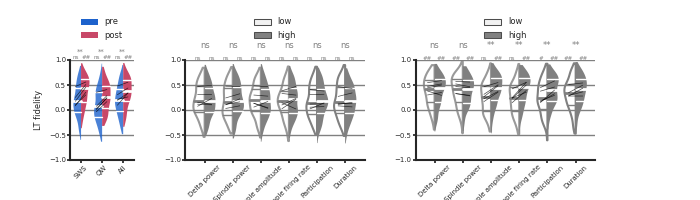

In [426]:
# Create figure and subplots
plotheight = 2
plotwidth = 7
font_size = 6

colors = [
    '#005CE9', # PRE
    '#DD335D' # # POST
    ] 
def get_epoch_color(i):
    if i<= 2:
        color = colors[0]    
    elif i <=4:
        color = colors[1]
    else:
        color = colors[2]
    return color
        
#------------------------------------------------------------------------------------------------------------
# Set up colors ans styles

sns.set_style('whitegrid') # Set style and context
sns.set_context('paper')

custom_params = {"axes.spines.top": False, "axes.spines.right": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':6,
    'axes.linewidth':1.5,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':8,
    'xtick.labelsize':6,
    'ytick.labelsize':5,
    'legend.fontsize':6,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

fig = plt.figure()
fig.set_size_inches([plotwidth, plotheight])
gs = GridSpec(nrows=1, ncols=5, figure=fig, hspace=0.3, wspace=0.8)

# def get_pval_statement(pvalue):
#     if pvalue < 0.0001:
#         pvalue_statement = 'P<1e-4'
#     else:
#         pvalue_statement = f'P={pvalue:.4f}'
#     return pvalue_statement

def get_pval_statement(pvalue, sign):
    if pvalue < 0.0001:
        pvalue_statement = sign*2    
    elif pvalue < 0.01:
        pvalue_statement = sign
    else:
        pvalue_statement = 'ns'
    return pvalue_statement


# Define a function to plot violin plots
def plot_violin(ax, data, color):
    alpha = 0.8
    # sns.violinplot(data=list(data.values()), ax=ax, color=color, inner='quartiles', cut=0, linewidth=0)
    vio = sns.violinplot(data=data, x = 'brain_state', y = 'LT_fidelity', hue="epoch", split=True, cut=0, inner='quartiles', ax=ax, palette=color, linewidth=0, capstyle='butt')
    for violin, curr_alpha in zip(ax.collections[::2], [alpha] * 6):
        violin.set_alpha(curr_alpha)
    for l in ax.lines:
        l.set_linestyle('-')
        l.set_linewidth(1)
        l.set_color('white')
        l.set_alpha(1)
    for l in ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(2)
        l.set_color('white')
        l.set_alpha(1)
    ax.grid(axis='y', color='gray', linewidth=1)
    for axis in ['left', 'bottom']:
        ax.spines[axis].set_linewidth(1.5)

    vio.legend(loc="upper center", bbox_to_anchor=(0.5, 1.5))
    vio.set_title("")
    


# Comapring NREM, QW, all-offline learned tunings between pre and post

def get_dataframe1(data):
    epochs = []    
    brain_states = []
    values = []

    # Loop over the keys and values in the dictionary
    for key, value in data.items():
        parts = key.split("_")
        epoch = parts[0]  # Join all parts except the last one
        brain_state = "_".join(parts[1:])  # Use the last part
        
        if len(np.unique(value)) > 1:
            for coeff in value:
                epochs.append(epoch)
                brain_states.append(brain_state)
                values.append(coeff)
                # Create a DataFrame from the lists
            df = pd.DataFrame({
            "epoch": epochs,
            "brain_state": brain_states,
            "LT_fidelity": values
            })
        else:
            epochs.append(epoch)
            brain_states.append(brain_state)
            values.append(value)
            df = pd.DataFrame({
            "epoch": epochs,
            "brain_state": brain_states,
            "p_value": values
            })

    
    return df


# for sleep_state_idx, sleep_state_name in enumerate(sleep_states):
ax0 = fig.add_subplot(gs[0, 0])

current_pf_correlation_values = {k:v for k, v in learned_tunings_place_field_corr_sessions_concat.items() if k in list(sleep_behavior_oscillation_names)[:6]} # k.endswith(sleep_state_name)
current_pf_correlation_values = get_dataframe1(current_pf_correlation_values)

current_pf_median_pvalues = {k:v for k, v in lt_pf_correlation_median_across_all_sessions_pvalue.items() if k in list(sleep_behavior_oscillation_names)[:6]}
current_pf_median_pvalues = get_dataframe1(current_pf_median_pvalues)


plot_violin(ax0, current_pf_correlation_values, colors)
ax0.set_xticklabels(sleep_states_plot_names, rotation=45, ha='center')
# ax0.set_xlabel("Sleep states")
ax0.set_xlabel("")
ax0.set_ylabel("LT fidelity")
ax0.set_ylim([-1,1])
ax0.set_yticks(np.arange(-1, 1.1, 0.5))


# For nrem, qw, and offline we separately plot the lines
for sleep_state_idx, sleep_state_name in enumerate(sleep_states):
    current_lt_pf_medians_indiv = [v for k, v in lt_pf_medians.items() if k.endswith(sleep_state_name)]
    current_lt_pf_medians_indiv = np.array(current_lt_pf_medians_indiv)
    current_lt_pf_medians_indiv = np.transpose(current_lt_pf_medians_indiv)

    [ax0.plot([sleep_state_idx-0.25, sleep_state_idx+0.25], indiv_session, linewidth= 0.5, color=(0,0,0, .7)) for indiv_session in current_lt_pf_medians_indiv]



brain_states = current_pf_correlation_values["brain_state"].unique()
for brain_state_idx, brain_state in enumerate(brain_states):

    # Add p-values for each individual combination of brain state and epoch
    for epoch_idx, epoch_name in enumerate(epoch_names):
        p_val = current_pf_median_pvalues.loc[(current_pf_median_pvalues["brain_state"] == brain_state) & (current_pf_median_pvalues["epoch"] == epoch_name), 'p_value'].reset_index(drop=True)
        ax0.text(brain_state_idx-0.25+0.5*epoch_idx, 1.02*ax0.get_ylim()[1], get_pval_statement(p_val[0], '#'), ha='center', fontsize=4, rotation=0, color='gray')


    # p_values of Wilcoxon sign rank test between the epochs for each brain state condition
    pre_values = current_pf_correlation_values.loc[(current_pf_correlation_values["brain_state"] == brain_state) & (current_pf_correlation_values["epoch"] == 'pre'), 'LT_fidelity'].reset_index(drop=True)
    post_values = current_pf_correlation_values.loc[(current_pf_correlation_values["brain_state"] == brain_state) & (current_pf_correlation_values["epoch"] == 'post'), 'LT_fidelity'].reset_index(drop=True)

    _, p_value = wilcoxon(pre_values, post_values, nan_policy='omit')

    ax0.annotate(get_pval_statement(p_value, '*'), xy = (brain_state_idx, ax0.get_ylim()[1]), xytext = (brain_state_idx, 1.1), color = 'gray', ha = "center", va="bottom", fontsize = 5)


ax0.tick_params(axis='both', which='major', labelsize=5, length=2, pad=1)



# Define a function to plot violin plots

def get_dataframe2(data):
    epochs = []    
    pbe_features = []
    levels = []
    values = []

    # Loop over the keys and values in the dictionary
    for key, value in data.items():
        parts = key.split("_")
        epoch = parts[0]  # Join all parts except the last one
        pbe_feature = "_".join(parts[1:-1])  # Use the last part
        level = parts[-1]

        if len(np.unique(value)) > 1:
            for coeff in value:
                epochs.append(epoch)
                pbe_features.append(pbe_feature)
                levels.append(level)   
                values.append(coeff)
                # Create a DataFrame from the lists
            df = pd.DataFrame({
            "epoch": epochs,
            "pbe_feature": pbe_features,
            "pbe_feature_level":levels,
            "LT_fidelity": values
            })
        else:
            epochs.append(epoch)
            pbe_features.append(pbe_feature)
            levels.append(level)
            values.append(value)
            df = pd.DataFrame({
            "epoch": epochs,
            "pbe_feature": pbe_features,
            "pbe_feature_level":levels,
            "p_value": values
            })
    return df

def plot_violin2(ax, data, color):
    alpha = 0.8
    # sns.violinplot(data=list(data.values()), ax=ax, color=color, inner='quartiles', cut=0, linewidth=0)
    vio = sns.violinplot(data=data, x = 'pbe_feature', y = 'LT_fidelity', hue="pbe_feature_level", split=True, cut=0, inner='quartiles', ax=ax, color=color, capstyle='butt')
    for violin, curr_alpha in zip(ax.collections[::2], [alpha] * 4):
        violin.set_alpha(curr_alpha)

    for l in ax.lines: # quartile lines
        l.set_linestyle('-')
        l.set_linewidth(1)

    for l in ax.lines[1::3]: # median lines
        l.set_linestyle('-')
        l.set_linewidth(2)

    for i, l in enumerate(ax.lines):
        if i % 6 < 3: 
            l.set_color(color)
        else: 
            l.set_color('white')

    ax.grid(axis='y', color='gray', linewidth=1)
    for axis in ['left', 'bottom']:
        ax.spines[axis].set_linewidth(1.5)

    violin_elements = vio.collections
    for i, elem in enumerate(violin_elements):
        if i % 2 == 0:  # Even indices (left side of the violin)
            elem.set_facecolor("none")  # Empty fill
            elem.set_edgecolor(color)  # Outline color
        else:  # Odd indices (right side of the violin)
            elem.set_facecolor(color)  # Filled with the same color
            elem.set_edgecolor("none")

    vio.legend(loc="upper center", bbox_to_anchor=(0.5, 1.5))
    vio.set_title("")
    


# Comparing learned tunings calculated based on different levels (low and high) of each lfp features (ripple amplitude, spindle power, and delta power) within each epoch 


for epoch_idx, epoch_name in enumerate(epoch_names):
    

    if epoch_idx == 0:
        ax1 = fig.add_subplot(gs[1:3])
    else:
        ax1 = fig.add_subplot(gs[3:])

    current_pf_correlation_values = {k:v for k, v in learned_tunings_place_field_corr_sessions_concat.items() if (k in list(sleep_behavior_oscillation_names)[6:]) & k.startswith(epoch_name)} # k.endswith(sleep_state_name)
    current_pf_correlation_values = get_dataframe2(current_pf_correlation_values)

    current_pf_median_pvalues = {k:v for k, v in lt_pf_correlation_median_across_all_sessions_pvalue.items() if (k in list(sleep_behavior_oscillation_names)[6:]) & k.startswith(epoch_name)}
    current_pf_median_pvalues = get_dataframe2(current_pf_median_pvalues)


    plot_violin2(ax1, current_pf_correlation_values, 'gray') #colors[epoch_idx]
    ax1.set_xticklabels(lfp_features_plot_names, rotation=45, ha='center')
    ax1.set_ylabel("")
    ax1.set_xlabel("")
    ax1.set_ylim([-1,1])
    ax1.set_yticks(np.arange(-1, 1.1, 0.5))

    # drawing the medians for each session
    pbe_features = current_pf_correlation_values["pbe_feature"].unique()
    for pbe_feature_idx, pbe_feature in enumerate(pbe_features):

        current_lt_pf_medians_indiv = [v for k, v in lt_pf_medians.items() if ('_'.join(k.split("_")[1:-1]) == pbe_feature) & k.startswith(epoch_name)]
        current_lt_pf_medians_indiv = np.array(current_lt_pf_medians_indiv)
        current_lt_pf_medians_indiv = np.transpose(current_lt_pf_medians_indiv)


        [ax1.plot([pbe_feature_idx-0.25, pbe_feature_idx+0.25], indiv_session, linewidth= 0.5, color=(0,0,0, .7)) for indiv_session in current_lt_pf_medians_indiv]




    for pbe_feature_idx, pbe_feature in enumerate(pbe_features):

        # Add p-values for each individual combination of pbe_feature and pbe_feature_level for the current epoch
        for pbe_feature_level_idx, pbe_feature_level in enumerate(['low', 'high']):        
            
            p_val = current_pf_median_pvalues.loc[
                (current_pf_median_pvalues["epoch"] == epoch_name) &
                (current_pf_median_pvalues["pbe_feature"] == pbe_feature) &
                (current_pf_median_pvalues["pbe_feature_level"] == pbe_feature_level),
                'p_value'
                ].reset_index(drop=True)
            
            ax1.text(pbe_feature_idx-0.25+0.5*pbe_feature_level_idx, ax1.get_ylim()[1], get_pval_statement(p_val[0], '#'), ha='center', fontsize=4, rotation=0, color='gray')


        # p_values of Wilcoxon sign rank test between the epochs for each brain state condition
        low_values = current_pf_correlation_values.loc[
            (current_pf_correlation_values["epoch"] == epoch_name) &
            (current_pf_correlation_values["pbe_feature"] == pbe_feature) & 
            (current_pf_correlation_values["pbe_feature_level"] == 'low'), 'LT_fidelity'].reset_index(drop=True)
        
        high_values = current_pf_correlation_values.loc[
            (current_pf_correlation_values["epoch"] == epoch_name) &
            (current_pf_correlation_values["pbe_feature"] == pbe_feature) & 
            (current_pf_correlation_values["pbe_feature_level"] == 'high'), 'LT_fidelity'].reset_index(drop=True)
        
        _, p_value = wilcoxon(low_values, high_values, nan_policy='omit')

        ax1.annotate(get_pval_statement(p_value, '*'), xy = (pbe_feature_idx, ax0.get_ylim()[1]), xytext = (pbe_feature_idx, 1.2), fontsize=6, color = 'gray', ha = "center", va="bottom")


    ax1.tick_params(axis='both', which='major', labelsize=5, length=2, pad=1)




plt.subplots_adjust(left=0.1, right= 0.85, bottom=0.2, top=0.7)
plt.tight_layout()
plt.show()

filename = 'learned_tunings_PBE_features_Miyawaki_dataset.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

